## 0. Import Libraries

### Note: ERA5 resampling is done, do not run ERA5 cells

In [1]:
import xarray as xr
import numpy as np

## 1. Resampling Task

In [2]:
path_general = r'/mnt/d/JupyterLab/Yuksek_Lisans/msc_thesis_data'

### 1.1 Open Data

In [3]:
# change these
season = 'JJA' # DJF or JJA
resample_time = 6 # 3 and 6
step_hour = 1
bias_algo = 'QDM' # EQM or QDM

#### 1.1.1 Model

In [4]:
dt_model = xr.open_dataset(fr'{path_general}/cosmo/yearly/BC/BC_{bias_algo}_Tr011_MPI_RF_PR_{season}_1hr_merged_198501_200512.nc',
                     chunks={"time": 10})

In [5]:
dt_model

<xarray.Dataset>
Dimensions:      (time: 46368, rlat: 59, rlon: 137)
Coordinates:
  * time         (time) datetime64[ns] 1985-06-01 ... 2005-08-31T23:00:00
    lon          (rlat, rlon) float32 dask.array<chunksize=(59, 137), meta=np.ndarray>
    lat          (rlat, rlon) float32 dask.array<chunksize=(59, 137), meta=np.ndarray>
  * rlon         (rlon) float32 -5.55 -5.44 -5.33 -5.22 ... 9.08 9.19 9.3 9.41
  * rlat         (rlat) float32 -4.11 -4.0 -3.89 -3.78 ... 1.94 2.05 2.16 2.27
Data variables:
    spatial_ref  int64 ...
    TOT_PREC     (time, rlat, rlon) float64 dask.array<chunksize=(10, 59, 137), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.6
    history:      Wed Feb 01 16:38:58 2023: cdo mergetime BC_QDM_Tr011_MPI_RF...
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...

### 1.2 Resample

not: buradaki shift time'i = resample(time) / step hour 

In [6]:
def resample_data(data, resample_time, step_hour):
    
    # resample_time: 3 hourly resample is expected
    # step_hour: 1 hourly data

    # calculate resampled data
    shift_time = int(resample_time / step_hour)
    resampled = data.shift(time=shift_time) \
                  .dropna(dim='time',
                          how='all') \
                  .resample(time=fr'{resample_time}H',
                            closed='right').sum()
    
    return resampled

#### 1.2.1 Model

In [7]:
resample_xhr_model = resample_data(dt_model, resample_time, step_hour)
resample_xhr_model = resample_xhr_model.dropna(dim='time')

In [8]:
resample_xhr_model

<xarray.Dataset>
Dimensions:      (rlon: 137, rlat: 59, time: 7748)
Coordinates:
  * rlon         (rlon) float32 -5.55 -5.44 -5.33 -5.22 ... 9.08 9.19 9.3 9.41
  * rlat         (rlat) float32 -4.11 -4.0 -3.89 -3.78 ... 1.94 2.05 2.16 2.27
  * time         (time) datetime64[ns] 1985-06-01 ... 2005-08-31T18:00:00
    lon          (rlat, rlon) float32 dask.array<chunksize=(59, 137), meta=np.ndarray>
    lat          (rlat, rlon) float32 dask.array<chunksize=(59, 137), meta=np.ndarray>
Data variables:
    spatial_ref  (time) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    TOT_PREC     (time, rlat, rlon) float64 dask.array<chunksize=(1, 59, 137), meta=np.ndarray>

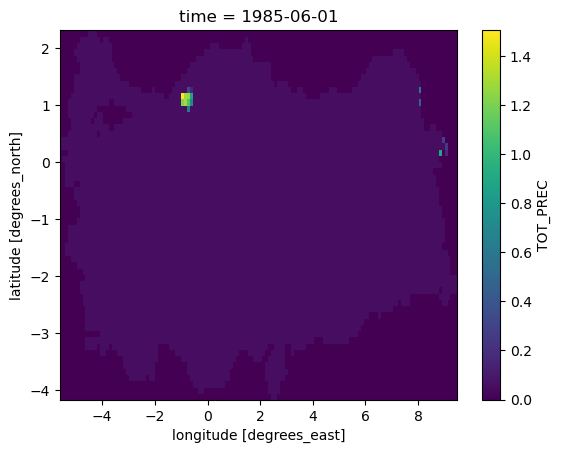

In [9]:
resample_xhr_model['TOT_PREC'][0].plot()

In [10]:
resample_xhr_model.to_netcdf(fr'{path_general}/cosmo/yearly/BC/BC_{bias_algo}_Tr011_MPI_RF_PR_{season}_{resample_time}hrsum_merged_198501_200512.nc',)

## 2. Check Resampling Details (For cross-checking purposes)

In [15]:
import visjobs

In [56]:
from visjobs.datas import get_MODEL
data = get_MODEL.pick_data(hour='00',latest=True,
                          model='GFS', hourly=False,
                          resolution = 0.25)['dpt2m'].isel(time=slice(0, 18),lon=0,lat=0)-273.15

/home/donmezk16/Downloads/anaconda3/envs/AFAD/lib/python3.9/site-packages/xarray/coding/times.py:119: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:0.0. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:0.0). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


Addressing Data:  http://nomads.ncep.noaa.gov:80/dods/gfs_0p25/gfs20221201/gfs_0p25_00z
Connected GFS Data via OpenDAP


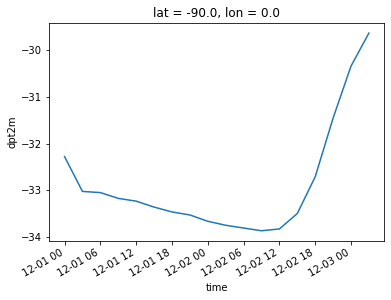

In [57]:
data.plot()

In [70]:
data

<xarray.DataArray 'dpt2m' (time: 18)>
array([-32.274628, -33.02069 , -33.045883, -33.16957 , -33.229156,
       -33.35611 , -33.460236, -33.524643, -33.660294, -33.745667,
       -33.804962, -33.863327, -33.824387, -33.494125, -32.706955,
       -31.449997, -30.33664 , -29.628754], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2022-12-01 ... 2022-12-03T03:00:00
    lat      float64 -90.0
    lon      float64 0.0

In [59]:
data.shift(time=3)

<xarray.DataArray 'dpt2m' (time: 18)>
array([       nan,        nan,        nan, -32.274628, -33.02069 ,
       -33.045883, -33.16957 , -33.229156, -33.35611 , -33.460236,
       -33.524643, -33.660294, -33.745667, -33.804962, -33.863327,
       -33.824387, -33.494125, -32.706955], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2022-12-01 ... 2022-12-03T03:00:00
    lat      float64 -90.0
    lon      float64 0.0

In [60]:
# not: buradaki shift time'i = resample(time) / step hour 
# in this case shift = 9 / 3 = 3
data.shift(time=3).dropna(dim='time',how='all').resample(time='9H', closed='right').sum()#.values

<xarray.DataArray 'dpt2m' (time: 6)>
array([ -32.274628,  -99.236145, -100.0455  , -100.9306  , -101.492676,
        -66.20108 ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2022-12-01 ... 2022-12-02T21:00:00
    lat      float64 -90.0
    lon      float64 0.0

In [41]:
data.resample(time='6H', closed='right').sum()#.values

<xarray.DataArray 'dpt2m' (time: 5)>
array([-32.274628, -66.066574, -66.39873 , -66.816345, -67.18494 ],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2022-11-30T18:00:00 ... 2022-12-01T18:00:00
    lat      float64 -90.0
    lon      float64 0.0

In [27]:
-33.02069 + -33.045883

-66.066573

In [30]:
-33.16957 + -33.229156

-66.39872600000001

note: closed=right works for us you can use

In [33]:
data.shift(time=-1).dropna(dim='time',how='all').resample(time='6H').sum()

<xarray.DataArray 'dpt2m' (time: 4)>
array([-66.066574, -66.39873 , -66.816345, -67.18494 ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2022-12-01 ... 2022-12-01T18:00:00
    lat      float64 -90.0
    lon      float64 0.0